## Confusion matrix for unfiltered trajectories.
This notebook computes the confusion matrix for unfiltered synthetic data for several thresholds. When the data is unfiltered, many change points are missed. However, as the threshold is lowered and the false negatives decrease, the false positive rate increases. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from cpdetect import cpDetector
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import *
try:
    import cPickle as pickle
except:
    import pickle
import os, glob

In [2]:
# Load all relavant data (synthetic trajectories and pickled detectors.)
trajs = np.load('synthetic_trajs.np.npy')
filtered_trajs = np.load('filtered_trajs.npy')
true_ts = pickle.load(open('true_ts.pickle', 'rb'))
true_step = pickle.load(open('step_synthetic.pickle', 'rb'))
files = [file for file in glob.glob('detector*')]
detectors = {f[9:-7]: pickle.load(open(f, 'rb')) for f in files}

In [4]:
# Calculate all confusion matrices. The rejection window here is 100 timepoints. 
cm = np.zeros((10, 2, 2))
for d in detectors:
    tp = 0
    fp = 0
    fn = 0
    for t in range(len(trajs)):
        true_positive = []
        false_negative = true_ts['traj_{}'.format(t)][:-1]
        false_positive = np.asarray(detectors[d].change_points['traj_{}'.format(t)]['ts'])
        index_neg = []
        for i, t_ts in enumerate(false_negative):
            for j, p_ts in enumerate(false_positive):
                if t_ts-100 <= p_ts <= t_ts+100:
                    true_positive.append(p_ts)
                    index_neg.append(i)
                    false_positive = np.delete(false_positive, j)
                    break
        false_negative = np.delete(false_negative, index_neg)
        # sanity check
        assert(len(true_ts['traj_{}'.format(t)][:-1]) == (len(true_positive) + len(false_negative)))
        assert(len(np.asarray(detectors[d].change_points['traj_{}'.format(t)]['ts']+28)) == 
               (len(true_positive) + len(false_positive)))
        tp += len(true_positive)
        fp += len(false_positive)
        fn += len(false_negative)
    m = int(d[-1])
    cm[m] = np.array(([tp, fp], [fn, 0]))

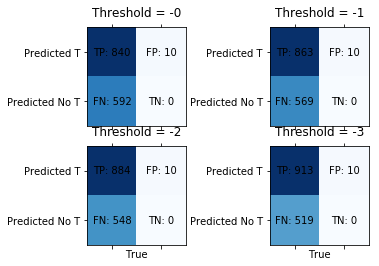

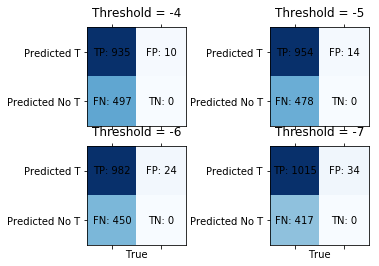

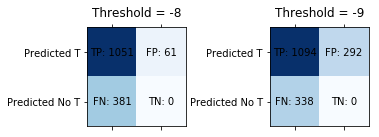

In [5]:
# Plot confusion matrices
key = [['TP', 'FN'], ['FP', 'TN']]
labelx = ['True T', 'No T']
labely = ['Predicted T', 'Predicted No T']
filename = 'confusion_matrix.pdf'
with PdfPages(filename) as pdf:
    for p in range(3):
        fig = plt.figure()
        for f in range(4):
            if p*4 + f > 9:
                break
            ax = fig.add_subplot(2, 2, f+1)
            confusion = ax.matshow(cm[p*4 + f], cmap='Blues')
            for (j, k), label in np.ndenumerate(cm[p*4+f]):
                l = key[k][j] + ': ' + str(int(label))
                ax.text(k,j,l,ha='center',va='center')
            plt.title('Threshold = -{}'.format(str(p*4+f)));
            if f in (2, 3):
                plt.xlabel('True')
            ax.set_xticklabels([])
            ax.set_yticklabels(['']+labely)
        pdf.savefig(bbox_inches='tight')
        